## Vamos utilizar todo o código já pronto, apenas atualizando a lista de times que passaram para as oitavas de final, e sucessivamente a medida que os jogos ocorram

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
from operator import itemgetter

In [2]:
with open('world_cup_sim/gb_V2.pkl' , 'rb') as f:
    gb = pickle.load(f)

In [4]:
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
url = "https://en.wikipedia.org/wiki/2022_FIFA_World_Cup_Group_{}"

In [5]:
base_df = pd.read_csv("world_cup_sim/team_stats.csv")
base_df.columns

Index(['date', 'team', 'score', 'suf_score', 'rank', 'rank_suf', 'rank_change',
       'total_points', 'result', 'rank_dif', 'points_by_rank', 'team_points'],
      dtype='object')

In [6]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = base_df[(base_df["team"] == team_1)].sort_values("date")
    last5 = base_df[(base_df["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

In [7]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

### A partir deste ponto, vamos avaliar as Oitavas de final com os times que de fato passaram para a próxima fase

In [8]:
thresh = 0.05

In [9]:
next_stage = []
for gr_ in groups:
    html_lists = pd.read_html(url.format(gr_))
    to_next_stage = html_lists[1].values
    
    next_stage.append([to_next_stage[0][1], to_next_stage[1][1]])
next_stage

[['Netherlands', 'Senegal'],
 ['England', 'United States'],
 ['Argentina', 'Poland'],
 ['France', 'Australia'],
 ['Japan', 'Spain'],
 ['Morocco', 'Croatia'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'South Korea']]

In [26]:
advanced = next_stage
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [27]:
def build_knockout_stage_matches(group_heads):
    control = []
    for a in range(0, len(group_heads*2), 1):
        if a < len(group_heads):
            if a % 2 == 0:
                control.append((group_heads*2)[a][0])
            else:
                control.append((group_heads*2)[a][1])
        else:
            if a % 2 == 0:
                control.append((group_heads*2)[a][1])
            else:
                control.append((group_heads*2)[a][0])
        
    return [[control[c], control[c+1]] for c in range(len(control)-1) if c%2 == 0]

In [28]:
for i in build_knockout_stage_matches(advanced):
    print(i)

['Netherlands', 'United States']
['Argentina', 'Australia']
['Japan', 'Croatia']
['Brazil', 'South Korea']
['Senegal', 'England']
['Poland', 'France']
['Spain', 'Morocco']
['Switzerland', 'Portugal']


In [29]:
def get_match_results(game):
    
    team_1 = find_stats(game[0])
    team_2 = find_stats(game[1])
    
    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)
    
    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    return [game[0], game[1], [team_1_prob, team_2_prob]]
    

In [31]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        playoffs[p] = build_knockout_stage_matches(advanced)
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(len(next_rounds)-1) if c%2 == 0]
        next_rounds = []
    for i in range(len(playoffs[p])):
        game = get_match_results(playoffs[p][i])
        playoffs[p][i] = game
        
        if actual_round != p:
            print("\n")
            print("-"*10)
            print("Starting simulation of %s"%(p))
            print("-"*10)

        team_1 = game[0]    
        team_1_prob = game[2][0]
        team_2 = game[1]
        team_2_prob = game[2][1]
        
        if team_1_prob > team_2_prob:
            print("%s vs. %s: %s advances with prob %.2f"%(team_1, team_2, team_1, team_1_prob*100.00))
            next_rounds.append(team_1)
        else:
            print("%s vs. %s: %s advances with prob %.2f"%(team_1, team_2, team_2, team_2_prob*100.00))
            next_rounds.append(team_2)
        
        actual_round = p




----------
Starting simulation of Round of 16
----------
Netherlands vs. United States: Netherlands advances with prob 53.75
Argentina vs. Australia: Argentina advances with prob 75.17
Japan vs. Croatia: Croatia advances with prob 58.79
Brazil vs. South Korea: Brazil advances with prob 74.89
Senegal vs. England: England advances with prob 63.78
Poland vs. France: France advances with prob 67.14
Spain vs. Morocco: Spain advances with prob 65.11
Switzerland vs. Portugal: Portugal advances with prob 56.60


----------
Starting simulation of Quarter-Final
----------
Netherlands vs. Argentina: Netherlands advances with prob 51.02
Croatia vs. Brazil: Brazil advances with prob 66.21
England vs. France: England advances with prob 51.44
Spain vs. Portugal: Spain advances with prob 52.25


----------
Starting simulation of Semi-Final
----------
Netherlands vs. Brazil: Brazil advances with prob 54.55
England vs. Spain: England advances with prob 52.50


----------
Starting simulation of Final
-

In [32]:
playoffs

{'Round of 16': [['Netherlands',
   'United States',
   [0.5375019854467492, 0.4624980145532508]],
  ['Argentina', 'Australia', [0.7516551935226725, 0.24834480647732746]],
  ['Japan', 'Croatia', [0.41205744170167047, 0.5879425582983295]],
  ['Brazil', 'South Korea', [0.7488767591010013, 0.25112324089899873]],
  ['Senegal', 'England', [0.36221292076258016, 0.6377870792374198]],
  ['Poland', 'France', [0.328581422645977, 0.6714185773540229]],
  ['Spain', 'Morocco', [0.6511108385146579, 0.3488891614853421]],
  ['Switzerland', 'Portugal', [0.4340056095035672, 0.5659943904964329]]],
 'Quarter-Final': [['Netherlands',
   'Argentina',
   [0.5102178589565887, 0.4897821410434113]],
  ['Croatia', 'Brazil', [0.33792449834610694, 0.6620755016538931]],
  ['England', 'France', [0.5144021513808086, 0.4855978486191915]],
  ['Spain', 'Portugal', [0.5224688162149136, 0.4775311837850864]]],
 'Semi-Final': [['Netherlands',
   'Brazil',
   [0.45453438598080714, 0.5454656140191929]],
  ['England', 'Spain', 

In [33]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

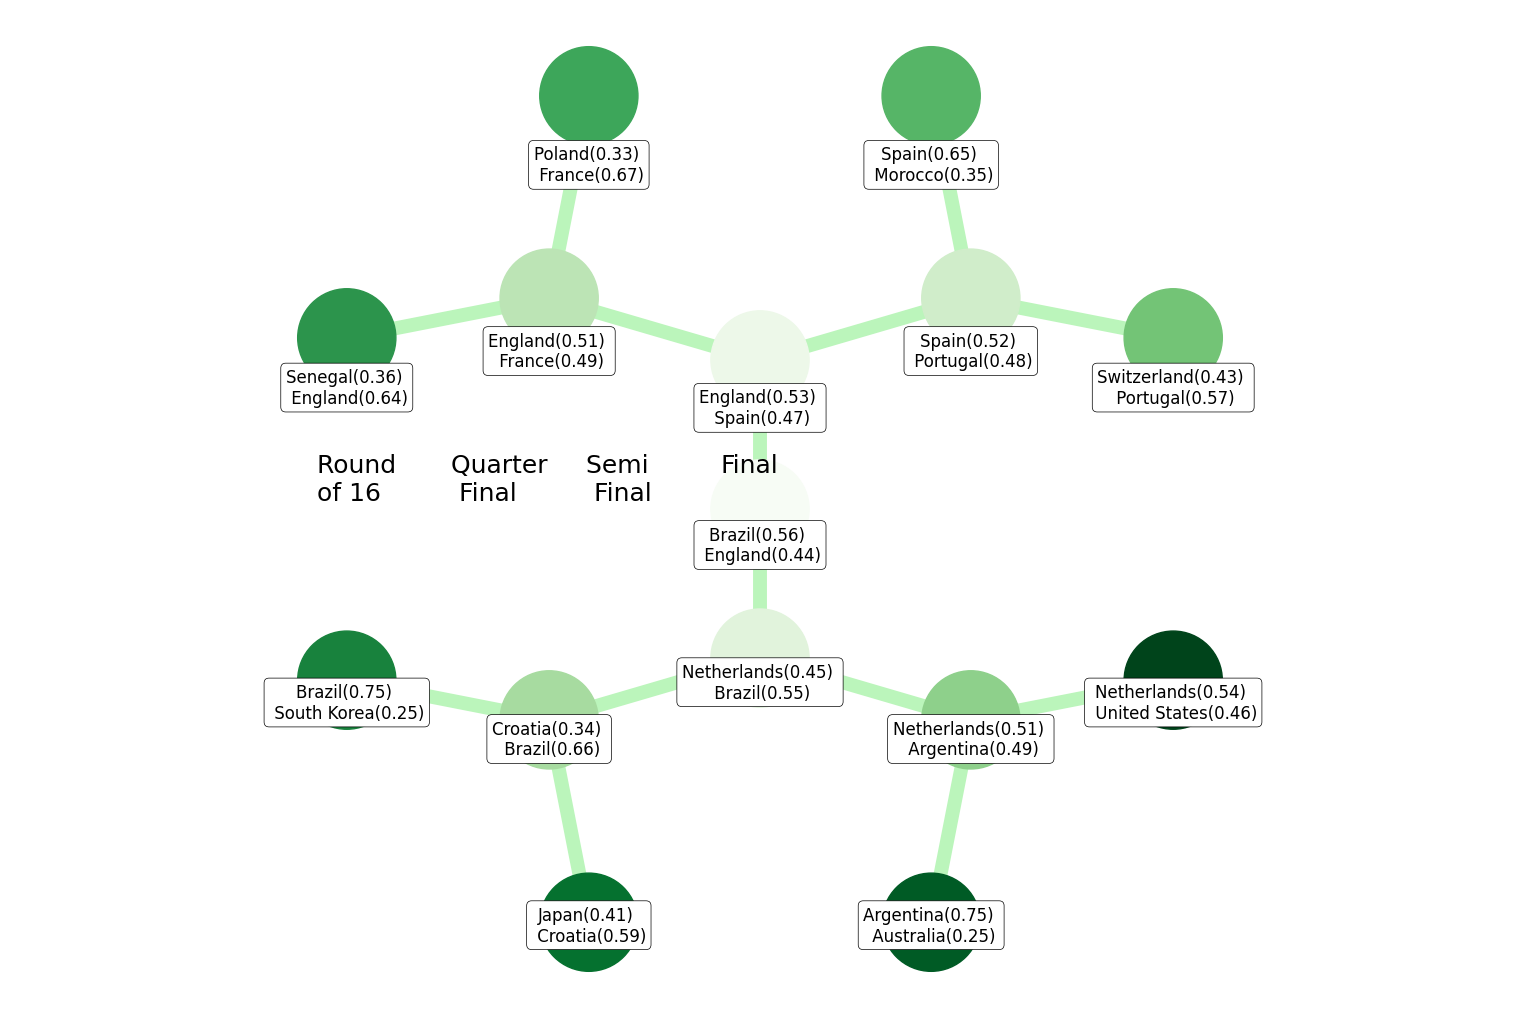

In [34]:
plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')
labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    

nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 65 
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()

## Análise sobre a sequência de jogos: Holanda vs EUA, Argentina vs Australia

### analisando os jogos hipotéticos que não ocorreram, caimos em uma espécie de "contradição". Não é possível criar uma relação transitiva usando os valores de probabilidade, como uma "medida de força" entre os times.  

Já que Argentina teria um desempenho melhor (maiores porcentagens de vencer) contra os 2 times eliminados da fase (Austrália e EUA), em relação à Holanda que teria probabilidades menores contra Austrália e EUA. Na sequencia, EUA seria um adversário mais forte a ser enfrentado tanto para Argentina bem como Holanda, e venceria Austrália com 65.03% de chance. 

No entanto, a transitividade dessa relação de força é "quebrada" quando executamos os calculos para o jogo Argentina vs Holanda, a Holanda venceria com probabilidade de 51.02%. 

In [40]:
jogo_1 = ['Netherlands', 'United States']
j1_results = get_match_results(jogo_1)
j1_results

['Netherlands', 'United States', [0.5375019854467492, 0.4624980145532508]]

In [42]:
jogo_2 = ['Argentina', 'Australia']
j2_results = get_match_results(jogo_2)
j2_results

['Argentina', 'Australia', [0.7516551935226725, 0.24834480647732746]]

In [43]:
# e Australia com Holanda ?
jogo_3 = ['Netherlands', 'Australia']
j3_results = get_match_results(jogo_3)
j3_results

['Netherlands', 'Australia', [0.7181337102978591, 0.28186628970214095]]

In [44]:
# e Estados Unidos com Argentina ?
jogo_4 = ['Argentina', 'United States']
j4_results = get_match_results(jogo_4)
j4_results

['Argentina', 'United States', [0.6765749946511356, 0.3234250053488644]]

In [45]:
jogo_5 = ['United States', 'Australia']
j5_results = get_match_results(jogo_5)
j5_results

['United States', 'Australia', [0.6503729856518181, 0.34962701434818194]]

In [46]:
jogo_6 = ['Argentina','Netherlands']
j6_results = get_match_results(jogo_6)
j6_results

['Argentina', 'Netherlands', [0.4897821410434113, 0.5102178589565887]]

## Análise sobre a sequência de jogos: Polônia vs França, Inglaterra vs Senegal 

### analisando os jogos hipotéticos que não ocorreram, caimos em uma espécie de "contradição". Não é possível criar uma relação transitiva usando os valores de probabilidade, como uma "medida de força" entre os times.  

Já que Senegal teria um desempenho melhor (maiores porcentagens de vencer) contra os 2 times que passaram de fase (França e Inglaterra), em relação à Polônia que teria probabilidades menores contra França e Inglaterra.  

No entanto, quando executamos os calculos para o jogo Polônia vs Senegal, a Polônia venceria com probabilidade de 56.36%

In [35]:
jogo_1 = ['Poland', 'France']
j1_results = get_match_results(jogo_1)
j1_results

['Poland', 'France', [0.328581422645977, 0.6714185773540229]]

In [36]:
jogo_2 = ['Senegal', 'England']
j2_results = get_match_results(jogo_2)
j2_results

['Senegal', 'England', [0.36221292076258016, 0.6377870792374198]]

In [37]:
# e Senegal com França ?
jogo_3 = ['Senegal','France']
j3_results = get_match_results(jogo_3)
j3_results

['Senegal', 'France', [0.3811260013936747, 0.6188739986063253]]

In [38]:
# e Polônia com Inglaterra ?
jogo_4 = ['Poland','England']
j4_results = get_match_results(jogo_4)
j4_results

['Poland', 'England', [0.30082173331192563, 0.6991782666880744]]

In [39]:
jogo_5 = ['Poland','Senegal']
j5_results = get_match_results(jogo_5)
j5_results

['Poland', 'Senegal', [0.5636361393005953, 0.4363638606994047]]

In [47]:
jogo_6 = ['France','England']
j6_results = get_match_results(jogo_6)
j6_results

['France', 'England', [0.4855978486191915, 0.5144021513808086]]